# TOKENIZE

In [ ]:
!pip install transformers --upgrade
!pip install sentencepiece
import torch 
import sentencepiece
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration
torch.manual_seed(42) 
np.random.seed(42) 

tokenizer = T5Tokenizer.from_pretrained("t5-base")

print(tokenizer)

In [9]:
max_length = 512

# start tokenizing
article_input_ids = tokenizer.batch_encode_plus(train['text'], return_tensors='pt', max_length=max_length, pad_to_max_length=True,truncation=True)['input_ids']
input_mask_ids = tokenizer.batch_encode_plus(train['text'], return_tensors='pt', max_length=max_length, pad_to_max_length=True,truncation=True)['attention_mask']
labels_id = tokenizer.batch_encode_plus(train['summary'], return_tensors='pt', max_length=max_length, pad_to_max_length=True,truncation=True)['input_ids']

# concatenate all ids column-wise for future use
id = torch.cat((article_input_ids, labels_id, input_mask_ids), 1)

print(article_input_ids.shape)
print(labels_id.shape)
print(id.shape)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


torch.Size([4500, 512])
torch.Size([4500, 512])
torch.Size([4500, 1536])


# TRAINING

In [10]:
# hyperparameters
lr=1e-05
eps=1e-08
batch_size= 2
epochs= 2
dataset= id
tokenizer = tokenizer

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

# load pre-trained t5-base model
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

Embedding(32100, 768)

In [11]:
def shift_tokens_right(input_ids, pad_token_id):
  """ 
  Shift input ids one token to the right, and wrap the last non pad token (usually <eos>).
  This is taken directly from source code for transformers.modeling_bart from Huggingface.
  """
  prev_output_tokens = input_ids.clone()
  index_of_eos = (input_ids.ne(pad_token_id).sum(dim=1) - 1).unsqueeze(-1)
  prev_output_tokens[:, 0] = input_ids.gather(1, index_of_eos).squeeze()
  prev_output_tokens[:, 1:] = input_ids[:, :-1]
  return prev_output_tokens

In [12]:
def training(dataset, lr, eps, batch_size, epochs, model, tokenizer, device):
  """ Train T5 model and print out training details."""

  model.train()

  train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  optimizer =  torch.optim.Adam(model.parameters(),lr=lr,eps=eps)
  
  loss_list = []
  for epoch in range(epochs):
    sum_loss = 0
    i = 0
    for _, id in enumerate(train_dataloader):
      input_ids, labels_id, input_mask_ids = id[:,:max_length], id[:,max_length:2*max_length], id[:,2*max_length:3*max_length]
      input_ids = input_ids.to(device)
      labels_id = labels_id.to(device)
      input_mask_ids = input_mask_ids.to(device)

      # decoder input is target shifted 1 token to the right 
      decoder_input_ids = shift_tokens_right(labels_id, model.config.pad_token_id)
      labels_id[labels_id[:, :] == model.config.pad_token_id] = -100

      optimizer.zero_grad()
      outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, labels=labels_id, attention_mask=input_mask_ids)
 
      loss = outputs.loss
      sum_loss += loss
      loss.backward()
      optimizer.step()

    print("epoch: {}/{} --> training loss: {}".format(epoch+1, epochs, sum_loss/dataset.shape[0])) 
    loss_list.append(sum_loss/dataset.shape[0])

  return loss_list


In [13]:
# save the model
model.save_pretrained('/..')

In [14]:
loss_list = training(dataset, lr, eps, batch_size, epochs, model, tokenizer, device)

epoch: 1/2 --> training loss: 1.5144710540771484
epoch: 2/2 --> training loss: 1.2834371328353882


In [15]:
def training_loss(loss_list, epochs):
  """ Draw training loss for different epochs """
  
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Training Loss--T5')
  plt.plot(range(1, epochs+1), loss_list, marker='o')
  plt.show


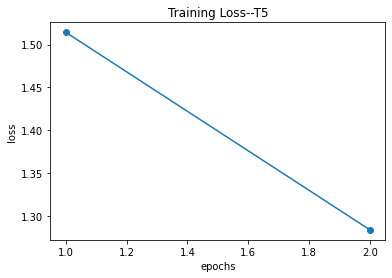

In [16]:
training_loss(loss_list, epochs=epochs)

# GENERATE

In [17]:
def truncate_sen(text):
  """ Trim the generated summaries by the last comma',' or dot'.' to form a complete sentence """

  text_split = list(text)
  text_split.reverse()

  # get the index of the last comma and dot, trim by the larger one
  if ',' in text_split and '.' in text_split:
    idx_comma = text_split.index(',')
    idx_dot = text_split.index('.')
    if idx_comma > idx_dot:
      text_split.reverse()
      idx1 = len(text_split) - idx_dot -1       
    else:
      text_split.reverse()
      idx1 = len(text_split) - idx_comma -1     

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)  
    return new_sen     
  
  # trim by last comma
  elif ',' in text_split:
    idx_comma = text_split.index(',')
    text_split.reverse()
    idx1 = len(text_split) - idx_comma -1 

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)
    return new_sen

  # trim by last dot
  elif '.' in text_split:
    idx_dot = text_split.index('.')
    text_split.reverse()
    idx1 = len(text_split) - idx_dot -1    

    new_text_split = text_split[:idx1+1]
    new_sen = ''.join(new_text_split)
    return new_sen

  # no trim
  else:
    return text


In [18]:
# import trained model when needed
# model = T5ForConditionalGeneration.from_pretrained('t5-base')
# model= model.to(device)
# model.resize_token_embeddings(len(tokenizer))

Embedding(32100, 768)

In [20]:
test_text = test['text']
test_summary = test['summary']

In [21]:
# generate summaries and output into a .csv file

model.eval()

with open('gen_summary_t5.csv', 'w', newline='') as csvfile:
    fieldnames = ['gensummary']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()

    # loop over all test samples, generate summaries and write them into rows in csv file
    for i in range(len(test_text)):
      text_input_ids = tokenizer.batch_encode_plus([test_text.iloc[i]],return_tensors='pt', max_length=max_length, padding=True, truncation=True)['input_ids'].to(device)
      mask_ids = tokenizer.batch_encode_plus([test_text.iloc[i]],return_tensors='pt', max_length=max_length, padding=True, truncation=True)['attention_mask'].to(device)
      summary_ids = model.generate(input_ids = text_input_ids,
                                   attention_mask = mask_ids,
                                   num_beams=3,
                                   no_repeat_ngram_size=3,
                                   max_length= 300,
                                   min_length = 200)
      summary_txt = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)
      # check if trim is needed
      summary_txt = truncate_sen(summary_txt)

      writer.writerow({'gensummary':summary_txt})    